<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/Classification_with_Neural_Decision_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import math

In [ ]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
)
train_data = pd.read_csv(train_data_url, header=None, names=CSV_HEADER)

test_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
)
test_data = pd.read_csv(test_data_url, header=None, names=CSV_HEADER)

In [ ]:
print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [ ]:
train_data

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [ ]:
test_data = test_data[1:]
test_data.income_bracket = test_data.income_bracket.apply(lambda value: value.replace(".", ""))

In [ ]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)

In [ ]:
# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = [
    "age",
    "education_num",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
]
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "workclass": sorted(list(train_data["workclass"].unique())),
    "education": sorted(list(train_data["education"].unique())),
    "marital_status": sorted(list(train_data["marital_status"].unique())),
    "occupation": sorted(list(train_data["occupation"].unique())),
    "relationship": sorted(list(train_data["relationship"].unique())),
    "race": sorted(list(train_data["race"].unique())),
    "gender": sorted(list(train_data["gender"].unique())),
    "native_country": sorted(list(train_data["native_country"].unique())),
}

# A list of the columns to ignore from the dataset.
IGNORE_COLUMN_NAMES = ["fnlwgt"]
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + IGNORE_COLUMN_NAMES else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = "income_bracket"
# A list of the labels of the target features.
TARGET_LABELS = [" <=50K", " >50K"]


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

target_label_lookup = StringLookup(vocabulary = TARGET_LABELS, mask_token=None, num_oov_indices = 0)



In [ ]:
def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size = 128):
  dataset = tf.data.experimental.make_csv_dataset(
      csv_file_path,
      batch_size=  batch_size,
      column_names = CSV_HEADER,
      column_defaults = COLUMN_DEFAULTS,
      label_name = TARGET_FEATURE_NAME,
      num_epochs = 1,
      header = False, 
      na_value = '?',
      shuffle = shuffle
  ).map(lambda features, target: (features, target_label_lookup(target)))
  return dataset.cache()

In [ ]:
def create_model_inputs():
  inputs = {}
  for feature_name in FEATURE_NAMES:
    if feature_name in NUMERIC_FEATURE_NAMES:
      inputs[feature_name] = layers.Input(name = feature_name, shape = (), dtype = tf.float32)
    else:
      inputs[feature_name] = layers.Input(name = feature_name, shape = (), dtype= tf.string)
  return inputs

In [ ]:
def encode_inputs(inputs):
  encoded_features = []
  for feature_name in inputs:
    if feature_name in CATEGORICAL_FEATURE_NAMES:
      vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
      # Create a lookup to convert a string values to an integer indices.
      # Since we are not using a mask token, nor expecting any out of vocabulary
      # (oov) token, we set mask_token to None and num_oov_indices to 0.
      lookup = StringLookup(vocabulary=vocabulary, mask_token = None, num_oov_indices=0)
      # Convert the string input values into integer indices.
      value_index = lookup(inputs[feature_name])
      embedding_dims = int(math.sqrt(lookup.vocabulary_size()))
      # Create an embedding layer with the specified dimensions.
      embedding = layers.Embedding(input_dim=lookup.vocabulary_size(), output_dim=embedding_dims)
      # Convert the index values to embedding representations.
      encoded_feature = embedding(value_index)

    else:
      # Use the numerical features as-is.
      encoded_feature = inputs[feature_name]
      if inputs[feature_name].shape[-1] is None:
        encoded_feature = tf.expand_dims(encoded_feature, -1)
    
    encoded_features.append(encoded_feature)

  encoded_features = layers.concatenate(encoded_features)
  return encoded_features 

In [ ]:
class NeuralDecisionTree(keras.Model):
  def __init__(self, depth, num_features, used_features_rate, num_classes):
    super(NeuralDecisionTree, self).__init__()
    self.depth = depth
    self.num_leaves = 2 ** depth
    self.num_classes = num_classes 

    # Create a mask for the randomly selected features.
    num_used_features = int(num_features * used_features_rate)
    one_hot = np.eye(num_features)
    sampled_feature_indicies = np.random.choice(np.arange(num_features), num_used_features, replace=False)
    self.used_features_mask = one_hot[sampled_feature_indicies]

    # Initialize the weights of the classes in leaves.
    self.pi = tf.Variable(initial_value = tf.random_normal_initializer()(shape = [self.num_leaves, self.num_classes]), dtype = 'float32', trainable=True)

    # Initialize the stochastic routing layer.
    self.decision_fn = layers.Dense(units=self.num_leaves, activation='sigmoid', name = 'decision')

  def call(self, features):
    batch_size = tf.shape(features)[0]

    # Apply the feature mask to the input features.
    features = tf.matmul(
        features, self.used_features_mask, transpose_b = True
    ) # [batch_size, num_used_features]
    # Compute the routing probabilities.
    
    decisions = tf.expand_dims(self.decision_fn(features), axis = 2) # [batch_size, num_leaves, 1]
    # Concatenate the routing probabilities with their complements.
    decisions = layers.concatenate([decisions, 1 - decisions], axis=2) # [batch_size, num_leaves, 2]

    mu = tf.ones([batch_size, 1, 1])

    begin_idx = 1 
    end_idx = 2 
    # Traverse the tree in breadth-first order.
    for level in range(self.depth):
      mu = tf.reshape(mu, [batch_size, -1, 1]) # [batch_size, 2 ** level, 1]
      mu = tf.tile(mu, (1,1,2)) # [batch_size, 2 ** level, 2]
      level_decisions = decisions[:, begin_idx : end_idx, :] # [batch_size, 2 ** level, 2]
      mu = mu * level_decisions # [batch_size, 2**level, 2]
      begin_idx = end_idx
      end_idx = begin_idx + 2 ** (level + 1)

    mu = tf.reshape(mu, [batch_size, self.num_leaves]) # [batch_size, num_leaves]
    probabilities = keras.activations.softmax(self.pi) # [num_leaves, num_classes]
    outputs = tf.matmul(mu, probabilities) # [batch_size, num_classes]
    return outputs

In [ ]:
class NeuralDecisionForest(keras.Model):
  def __init__(self, num_trees, depth, num_features, used_features_rate, num_classes):
    super(NeuralDecisionForest, self).__init__()
    self.ensemble = []

    for _ in range(num_trees):
      self.ensemble.append(NeuralDecisionTree(depth, num_features, used_features_rate, num_classes))

  
  def call(self, inputs):
    # Initialize the outputs: a [batch_size, num_classes] matrix of zeros.
    batch_size = tf.shape(inputs)[0]
    outputs = tf.zeros([batch_size, num_classes])

    # Aggregate the outputs of trees in the ensemble.
    for tree in self.ensemble:
      outputs += tree(inputs)
    # Divide the outputs by the ensemble size to get the average.
    outputs /= len(self.ensemble)
    return outputs 

In [ ]:
learning_rate = 0.01
batch_size = 265
num_epochs = 10
hidden_units = [64, 64]

def run_experiment(model):
  model.compile(optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(),
                metrics = [keras.metrics.SparseCategoricalAccuracy()])
  
  print('start training the model..')
  train_dataset = get_dataset_from_csv(train_data_file, shuffle=True, batch_size=batch_size)

  model.fit(train_dataset, epochs = num_epochs)
  print('Model training finished')

  print("Evaluating the model on the test data...")
  test_dataset = get_dataset_from_csv(test_data_file, batch_size=batch_size)

  _, accuracy = model.evaluate(test_dataset)
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [ ]:
num_trees = 10
depth = 10
used_features_rate = 1.0
num_classes = len(TARGET_LABELS)

def create_tree_model():
  inputs = create_model_inputs()
  features = encode_inputs(inputs)
  features = layers.BatchNormalization()(features)
  num_features = features.shape[1]

  tree = NeuralDecisionTree(depth, num_features, used_features_rate, num_classes)

  outputs = tree(features)
  model = keras.Model(inputs = inputs, outputs = outputs)
  return model 

tree_model = create_tree_model()

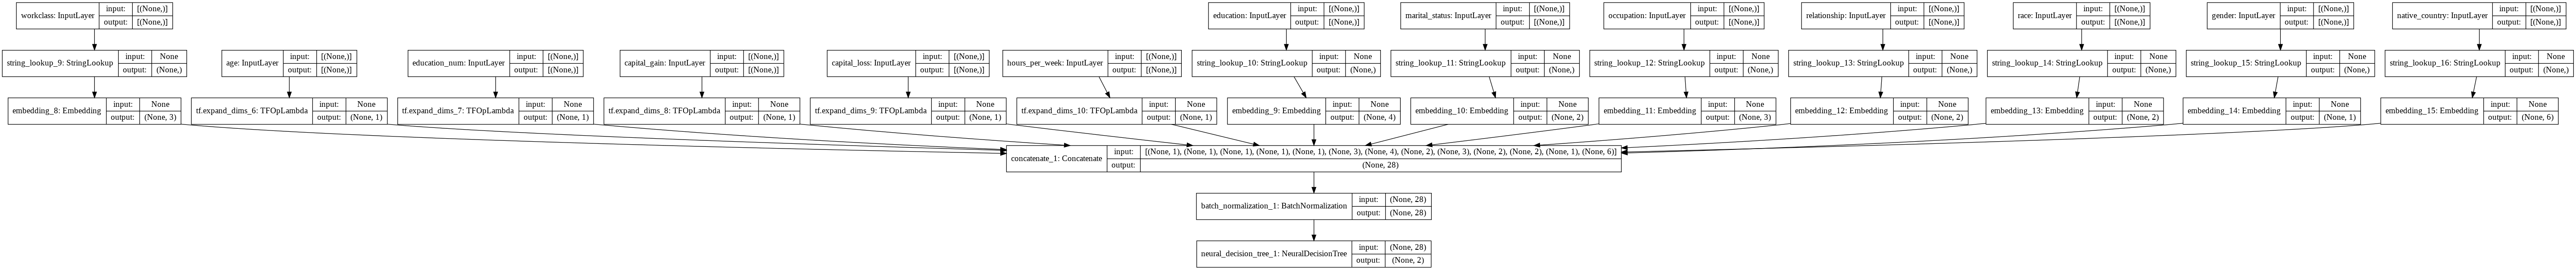

In [ ]:
keras.utils.plot_model(tree_model, show_shapes=True)

In [ ]:
run_experiment(tree_model)

start training the model..
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['fnlwgt'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


123/123 [==============================] - 6s 10ms/step - loss: 0.4379 - sparse_categorical_accuracy: 0.8315
Epoch 2/10
123/123 [==============================] - 1s 7ms/step - loss: 0.3341 - sparse_categorical_accuracy: 0.8507
Epoch 3/10
123/123 [==============================] - 1s 7ms/step - loss: 0.3219 - sparse_categorical_accuracy: 0.8539
Epoch 4/10
123/123 [==============================] - 1s 7ms/step - loss: 0.3162 - sparse_categorical_accuracy: 0.8546
Epoch 5/10
123/123 [==============================] - 1s 7ms/step - loss: 0.3120 - sparse_categorical_accuracy: 0.8570
Epoch 6/10
123/123 [==============================] - 1s 7ms/step - loss: 0.3081 - sparse_categorical_accuracy: 0.8586
Epoch 7/10
123/123 [==============================] - 1s 7ms/step - loss: 0.3039 - sparse_categorical_accuracy: 0.8620
Epoch 8/10
123/123 [==============================] - 1s 7ms/step - loss: 0.2996 - sparse_categorical_accuracy: 0.8641
Epoch 9/10
123/123 [==============================] - 1s 7

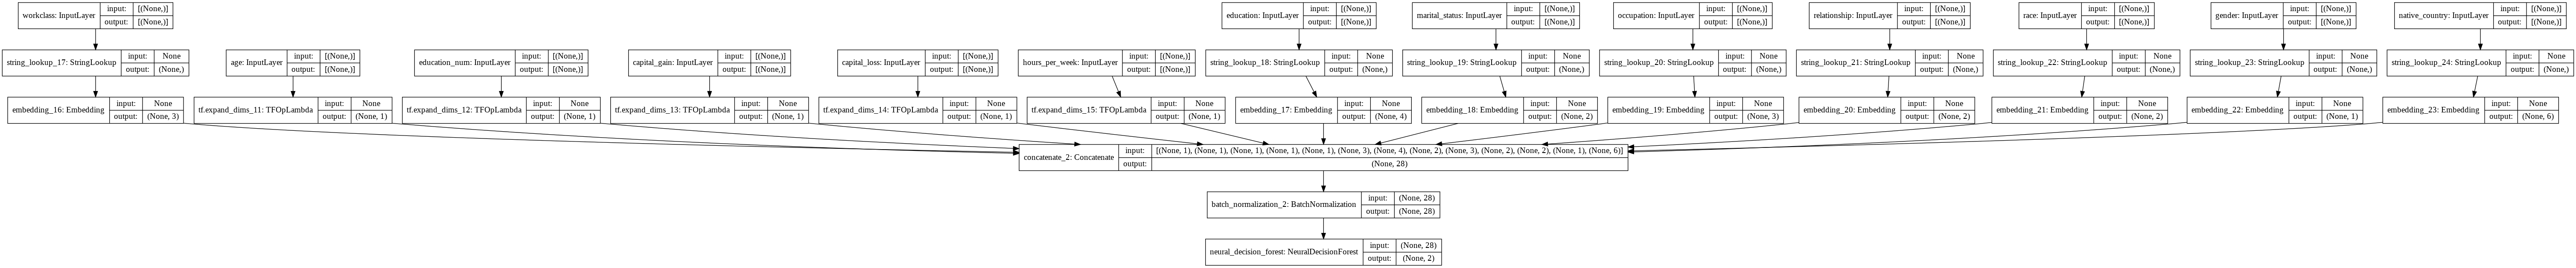

In [ ]:
num_trees = 25
depth = 5
used_features_rate = 0.5

def create_forest_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)
    features = layers.BatchNormalization()(features)
    num_features = features.shape[1]

    forest_model = NeuralDecisionForest(
        num_trees, depth, num_features, used_features_rate, num_classes
    )

    outputs = forest_model(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


forest_model = create_forest_model()
keras.utils.plot_model(forest_model, show_shapes=True)

In [ ]:
run_experiment(forest_model)


start training the model..
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['fnlwgt'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


123/123 [==============================] - 14s 32ms/step - loss: 0.4580 - sparse_categorical_accuracy: 0.8128
Epoch 2/10
123/123 [==============================] - 4s 29ms/step - loss: 0.3335 - sparse_categorical_accuracy: 0.8497
Epoch 3/10
123/123 [==============================] - 4s 29ms/step - loss: 0.3209 - sparse_categorical_accuracy: 0.8525
Epoch 4/10
123/123 [==============================] - 3s 28ms/step - loss: 0.3158 - sparse_categorical_accuracy: 0.8538
Epoch 5/10
123/123 [==============================] - 4s 29ms/step - loss: 0.3126 - sparse_categorical_accuracy: 0.8543
Epoch 6/10
123/123 [==============================] - 4s 29ms/step - loss: 0.3102 - sparse_categorical_accuracy: 0.8554
Epoch 7/10
123/123 [==============================] - 4s 29ms/step - loss: 0.3081 - sparse_categorical_accuracy: 0.8565
Epoch 8/10
123/123 [==============================] - 4s 29ms/step - loss: 0.3063 - sparse_categorical_accuracy: 0.8573
Epoch 9/10
123/123 [==============================